In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time
import pandas as pd
%matplotlib inline
plt.rcParams['figure.figsize']=[20,20]

W0213 21:18:34.086276 140384084764416 deprecation_wrapper.py:118] From /usr/local/lib/python3.5/dist-packages/tensorflow/__init__.py:99: The name tf.AUTO_REUSE is deprecated. Please use tf.compat.v1.AUTO_REUSE instead.

W0213 21:18:34.089020 140384084764416 deprecation_wrapper.py:118] From /usr/local/lib/python3.5/dist-packages/tensorflow/__init__.py:99: The name tf.AttrValue is deprecated. Please use tf.compat.v1.AttrValue instead.

W0213 21:18:34.090649 140384084764416 deprecation_wrapper.py:118] From /usr/local/lib/python3.5/dist-packages/tensorflow/__init__.py:99: The name tf.COMPILER_VERSION is deprecated. Please use tf.version.COMPILER_VERSION instead.

W0213 21:18:34.092150 140384084764416 deprecation_wrapper.py:118] From /usr/local/lib/python3.5/dist-packages/tensorflow/__init__.py:99: The name tf.CXX11_ABI_FLAG is deprecated. Please use tf.sysconfig.CXX11_ABI_FLAG instead.

W0213 21:18:34.093575 140384084764416 deprecation_wrapper.py:118] From /usr/local/lib/python3.5/dist-pac

## purpose from this tutorial

* 1.define a regression loss function using real data.
    It's easy to using tensorflow to define loss,parameters,and grad respect to loss
* 2.draw the error courtouf
* 3.compare your optimizer and tf implement
* 4.how differnt alg converge

In [2]:
def f(W,fileName='ex1data1.txt'):
        '''
            load a linear regression data,
            then using tensorflow to construct ,loss= mean [(WX-Y)**2] X=[1,x].T Y=[y].T
            
            W is a input,can be any tensor(PlaceHolder,Variable) need Have shape [?,2]
        
            return loss,W
        '''
        df=pd.read_csv(fileName,names=['x','y'])
        df=np.array(df)
        
        
        xs,ys=x,y=df[:,0:1].T,df[:,1:2].T #shape [1,m]
        xs=np.concatenate([np.ones_like(xs),xs],axis=0) #shape [2,m]
        assert(xs.shape[0]==2)
        
        #convert numpy array 2 tensor
        X=tf.constant(value=xs,dtype=tf.float32) #shape (2,m)
        Y=tf.constant(value=ys,dtype=tf.float32) #shape (1,m)

        Yhat=tf.matmul(W,X)
        loss=tf.reduce_mean((Yhat-Y)**2,axis=1)
        

        return loss
def df(loss,W):
    #loss is a scalar
    dW=tf.gradients(loss,W)[0]
    return dW

# get a rough range of the optimal W

In [3]:
tf.reset_default_graph()
sess=tf.Session()
W=tf.get_variable(name='W',shape=[1,2])
loss=f(W,'ex1data1.txt')

opt=tf.train.AdamOptimizer(0.1).minimize(loss)
start=time.time()

sess.run(tf.global_variables_initializer())
for i in range(10000):
    _l,_=sess.run([loss,opt])
optimal_W=sess.run(W)

print(optimal_W)
print('time consume:{:.4}'.format(time.time()-start))
sess.close()

W0213 21:18:36.626559 140384084764416 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow_core/python/ops/math_grad.py:1206: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


[[-3.895744   1.1930708]]
time consume:6.134


## The draw the contour graph

In [4]:
#define the showing range,and prepare for compute loss 
w1,w2=optimal_W[0][0],optimal_W[0][1]


def cost_hyperplane(r=-1,points=2000):
    '''
        points:num of point along one axis
    '''
    w1_range=np.linspace(w1-r,w1+r,points)
    w2_range=np.linspace(w2+r,w2-r,points) #notice reverse order
    np_W1,np_W2=np.meshgrid(w1_range,w2_range) #shape[400,300]
    np_params=np.stack([np_W1.ravel(),np_W2.ravel()],axis=1) #shape (12000,2)
    #lanch tensorflow graph
    tf.reset_default_graph()
    sess=tf.Session()
    W=tf.placeholder(shape=[None,2],dtype=tf.float32)
    loss=f(W,'ex1data1.txt')

    #get loss
    np_loss=sess.run(loss,feed_dict={W:np_params})
    np_loss=np.reshape(np_loss,np_W1.shape)

    plt.contourf(np_W1,np_W2,np_loss)
    plt.xlabel('w1')
    plt.ylabel('w2')
#     plt.colorbar()
    sess.close()

<a href='https://www.tensorflow.org/api_docs/python/tf/train/RMSPropOptimizer#class_rmspropoptimizer'>rmsprop</a>
<a href='https://www.tensorflow.org/api_docs/python/tf/train/MomentumOptimizer'>momentum</a>
<a hre='https://www.tensorflow.org/api_docs/python/tf/train/GradientDescentOptimizer'>SGD</a>
<a href='http://cs231n.github.io/neural-networks-3/#sgd'>cs231n</a>

In [5]:
def update_with_tensorflow(x0,trace,sess,steps,optimizer):
    W=tf.Variable(initial_value=x0,dtype=tf.float32)
    cost=f(W)
    train_step=optimizer.minimize(cost)
    sess.run(tf.global_variables_initializer())
    for k in range(steps):
        _,_w=sess.run([train_step,W])
        trace.append(_w)
def init_param():
    W=tf.placeholder(shape=[1,2],dtype=tf.float32)
    cost=f(W)
    dW=df(cost,W)
    return W,cost,dW

def sgd(x0,lr=0.01,steps=10,use_tf=False):
    '''
        x0 is initial value,have shape [1,2]
    '''
    tf.reset_default_graph()
    sess=tf.Session()
    trace=[x0]
    
    if use_tf:
        update_with_tensorflow(x0,trace,sess,steps,tf.train.GradientDescentOptimizer(lr))
        return np.squeeze(np.array(trace))
    else:
        x=x0
        W,cost,dW=init_param()
        for k in range(steps):
            dx=sess.run(dW,feed_dict={W:x})
            x=x-lr*dx
            trace.append(x)     
        return np.squeeze(np.array(trace))

def sgd_momentum(x0,lr=0.01,steps=10,beta=0.9,use_tf=False):
    tf.reset_default_graph()
    sess=tf.Session()
    trace=[x0]

    
    if use_tf:
        update_with_tensorflow(x0,trace,sess,steps,tf.train.MomentumOptimizer(lr,momentum=beta))
        return np.squeeze(np.array(trace))
    else:
        x,v=x0,0
        W,cost,dW=init_param()
        for k in range(steps):
            dx=sess.run(dW,feed_dict={W:x})
            v=v*beta+dx*(1-beta)
            x=x-lr*v
            trace.append(x)
        return np.squeeze(np.array(trace))

def rms_prop(x0,lr=0.01,steps=10,beta=0.9,eps=1e-10,use_tf=False):
    tf.reset_default_graph()
    sess=tf.Session()
    trace=[x0]
    
    if use_tf:
        #you can conbine momentum and decay,decay is the rate of magnitude
        update_with_tensorflow(x0,trace,sess,steps,
                               tf.train.RMSPropOptimizer(lr,momentum=0,decay=beta,epsilon=eps))
        return np.squeeze(np.array(trace))
    else:    
        x,v=x0,0
        W,cost,dW=init_param()
        for k in range(steps):
            dx=sess.run(dW,feed_dict={W:x})
            v=v*beta+(dx**2)*(1-beta)
            x=x-lr*dx/(np.sqrt(v)+eps)
            trace.append(x)
        return np.squeeze(np.array(trace))
def adam(x0,lr,steps=10,beta1=0.9,beta2=0.999,eps=1e-8,use_tf=False):
    tf.reset_default_graph()
    sess=tf.Session()
    trace=[x0]
    
    if use_tf:
        update_with_tensorflow(x0,trace,sess,steps,
                               tf.train.AdamOptimizer(lr,beta1=beta1,beta2=beta2,epsilon=eps))
        return np.squeeze(np.array(trace))
    else:
        x,m,v=x0,0,0
        W,cost,dW=init_param()
        for k in range(1,steps+1):
            dx=sess.run(dW,feed_dict={W:x})
            m=beta1*m+(1-beta1)*dx
            v=beta2*v+(1-beta2)*(dx**2)
            '''
            bias correction mechanism, which compensates for the fact that 
            in the first few time steps the vectors m,v are both initialized 
            nd therefore biased at zero, before they fully “warm up”
            '''
            mt=m/(1-beta1**k)
            vt=v/(1-beta2**k)
#             mt,vt=m,v
            x=x-lr*mt/(np.sqrt(vt)+eps)
            trace.append(x)
        return np.squeeze(np.array(trace))

W0213 21:20:32.940804 140384084764416 deprecation_wrapper.py:118] From /usr/local/lib/python3.5/dist-packages/tensorflow_estimator/python/estimator/api/_v1/estimator/__init__.py:10: The name tf.estimator.inputs is deprecated. Please use tf.compat.v1.estimator.inputs instead.



NameError: name 'beta' is not defined

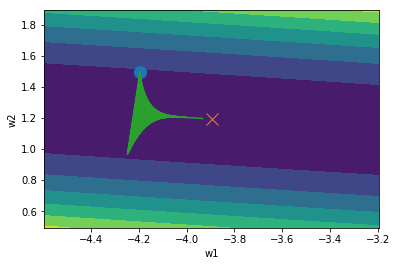

In [6]:
x0=np.array([[w1-0.3,w2+0.3]]) #upleft conner of optimal value
steps=500
lr=0.012

###################optimal value and initial state###############################
cost_hyperplane(r=0.7)
plt.plot(x0[0][0],x0[0][1],'o', markersize=12)
plt.plot(w1,w2,'x', markersize=12)
#################################################################################


####################SGD##########################################################
# path=sgd(x0,lr=lr,steps=steps)
# plt.plot(path[:,0],path[:,1])


path=sgd(x0,lr=lr,steps=steps,use_tf=True)
plt.plot(path[:,0],path[:,1])
##################################################################################

'''
tensorflow,implemtnt is:
    accumulation = menment/(1-menment) * accumulation + gradient
    
    variable -= learning_rate * accumulation
my implement is:
    accumulation=beta*accumulation+(1-bata)*grad
    variable -= learning_rate * accumulation
    
    so equiment to tensorflow's menment =beta
        lr=lr*(1-beta)
'''
####################sgd with momentum#############################################
# beta=0.9
# path=sgd_momentum(x0,lr=lr,steps=steps,beta=beta)
# plt.plot(path[:,0],path[:,1])

path=sgd_momentum(x0,lr=lr*(1-beta),steps=steps,beta=beta,use_tf=True)
plt.plot(path[:,0],path[:,1])
###################################################################################


####################rmsprop########################################################
decay=0.9
# path=rms_prop(x0,lr=lr,steps=steps,beta=decay)
# plt.plot(path[:,0],path[:,1])

path=rms_prop(x0,lr=lr,steps=steps,beta=decay,use_tf=True) #beta is decay argument in tensorflow
plt.plot(path[:,0],path[:,1])

##################################################################################

####################Adam  ########################################################
beta,decay=0.9,0.999

path=adam(x0,lr=lr,steps=steps,beta1=beta,beta2=decay)
plt.plot(path[:,0],path[:,1],'b')

# path=adam(x0,lr=lr,steps=steps,beta1=beta,beta2=decay,use_tf=True)
# plt.plot(path[:,0],path[:,1],'b')

##################################################################################
plt.legend(['start point','optimal target'
#            ,'sgd'
            ,'sgd_tensorflow'
#            ,'sgd_moment'
            ,'sgd_moment_tensorflow'
#             ,'rmsprop'
            ,'rmsprop_tensorflow'
#             ,'adam'
            ,'adam_tensorflow'
           ])

